A clear description of the dependent and why the analysis used was chosen. (10 %)

In this Analysis, we are classifying the column "Class" in the dataset. Hence this becomes a dependent variable.
* Class = 1 when there has been a ClinVar variant will have conflicting classificaton. 
* Class = 0 when there is consistent classification

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

1. Likely Benign or Benign
2. VUS
3. Likely Pathogenic or Pathogenic

In [1]:
import pandas as pd
import numpy as np

In [2]:
df =pd.read_csv("cleanData.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To vectorize the dataset, we perform feature hashing on all the columns having more unique values and one hot encode the rest

In [3]:
from sklearn.feature_extraction import FeatureHasher

In [4]:
featureHashCols=[]
oneHotCols=[]
df_finalFeatures=df
for i in range(len(df.columns)):
    if (df.dtypes[i]==object):
        df[df.columns[i]]=df[df.columns[i]].astype('str')
        if(len(np.unique(df[df.columns[i]]))>10):
            X_hash = df[df.columns[i]].copy()
            h = FeatureHasher(n_features=5,input_type="string")
            X_hash = h.transform(X_hash.values)
            x=X_hash.toarray()
            x=pd.DataFrame(x)
            nameList = {}
            for j in x.columns.values:
                nameList[j] = df.columns[i]+str(j+1)


            x.rename(columns = nameList, inplace = True)
            featureHashCols.append(x)
            df_finalFeatures=df_finalFeatures.drop([df.columns[i]],axis=1)
        else:
            X_oneHot=pd.get_dummies(df[df.columns[i]])
            oneHotCols.append(X_oneHot)
            df_finalFeatures=df_finalFeatures.drop([df.columns[i]],axis=1)

In [5]:
for frame in featureHashCols:
    df_finalFeatures=pd.concat([df_finalFeatures, frame], axis=1)

In [6]:
for frame in oneHotCols:
    df_finalFeatures=pd.concat([df_finalFeatures, frame], axis=1)

In [7]:
len(df_finalFeatures.columns)

113

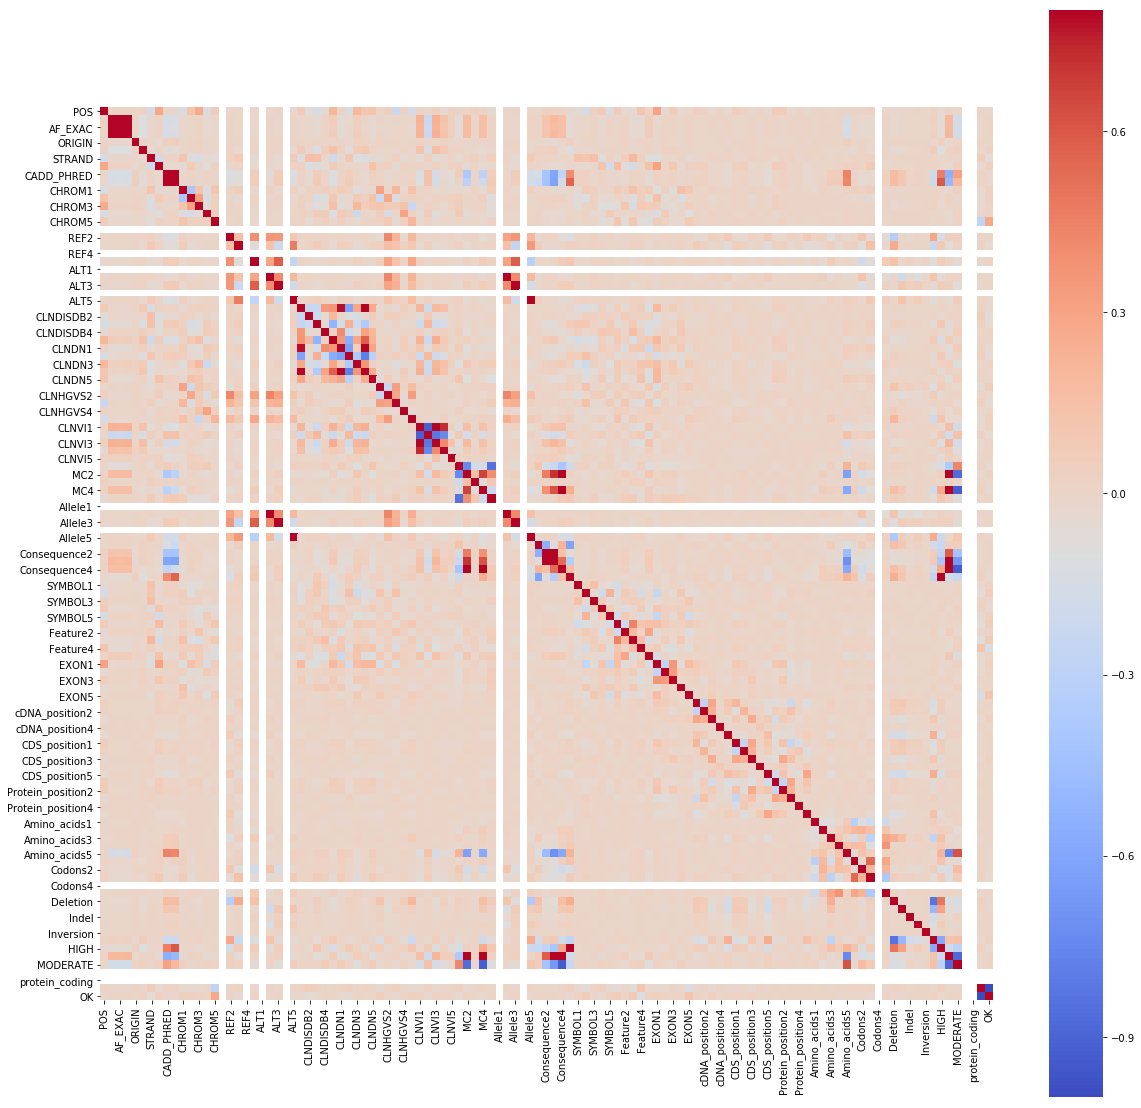

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.close('all')
plt.figure(figsize=(20,20))
sns.heatmap(df_finalFeatures.corr(), vmax=.8, square=True, cmap=cm.coolwarm)
plt.show()

In [35]:
#Classification using Logistic regression, Random forest, descion tree

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [11]:
y = df_finalFeatures['CLASS']
X = df_finalFeatures.drop(columns=['CLASS'], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_lr))

Classification Report :
               precision    recall  f1-score   support

          0       0.76      1.00      0.86      8489
          1       0.00      0.00      0.00      2654

avg / total       0.58      0.76      0.66     11143



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_dt))

Classification Report :
               precision    recall  f1-score   support

          0       0.80      0.94      0.87      8489
          1       0.58      0.26      0.36      2654

avg / total       0.75      0.78      0.75     11143



In [15]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_rf))

Classification Report :
               precision    recall  f1-score   support

          0       0.81      0.95      0.88      8489
          1       0.64      0.31      0.42      2654

avg / total       0.77      0.79      0.77     11143



Let us perform a grid search on each of the algorithms used

In [16]:
from sklearn.model_selection import GridSearchCV

In [182]:
lr.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [18]:
C = np.logspace(0, 4, 10)
penalty = ['l1', 'l2']
max_iter=[100,1000,5000]

In [19]:
hyperparameters = dict(C=C, max_iter=max_iter, penalty=penalty)
clf = GridSearchCV(lr, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
pred_lr=best_model.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_lr))

Classification Report :
               precision    recall  f1-score   support

          0       0.78      0.96      0.86      8489
          1       0.49      0.13      0.20      2654

avg / total       0.71      0.76      0.70     11143



In [20]:
best_model.best_estimator_.get_params()['penalty']

'l1'

In [21]:
best_model.best_estimator_.get_params()['C']

1.0

In [22]:
best_model.best_estimator_.get_params()['max_iter']

5000

In [23]:
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [24]:
criterion=['gini','entropy']
max_depth=[4,6,10,15,None]
random_state=[10,100,200]

In [25]:
hyperparameters_dt = dict(criterion=criterion, max_depth=max_depth, random_state=random_state)
clf_dt = GridSearchCV(dt, hyperparameters_dt, cv=5, verbose=0)
best_model_dt = clf_dt.fit(X_train, y_train)

In [205]:
pred_dt=best_model_dt.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_dt))

Classification Report :
               precision    recall  f1-score   support

          0       0.83      0.90      0.86      8400
          1       0.58      0.43      0.49      2743

avg / total       0.77      0.78      0.77     11143



In [206]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [208]:
bootstrap=[True,False]

In [209]:
hyperparameters_rf = dict(bootstrap=bootstrap, criterion=criterion, max_depth=max_depth, random_state=random_state)
clf_rf = GridSearchCV(rf, hyperparameters_rf, cv=5, verbose=0)
best_model_rf = clf_rf.fit(X_train, y_train)

In [210]:
pred_rf=best_model_rf.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_rf))

Classification Report :
               precision    recall  f1-score   support

          0       0.82      0.95      0.88      8400
          1       0.71      0.35      0.47      2743

avg / total       0.79      0.80      0.78     11143

